# Best Neighborhoods with Vegetarian friendly restaurants in Toronto, Canada 
### IBM's Applied Data Science Capstone
#### Anthony Splendor

### Scraping the Wiki Page

We first need to find the different neighborhoods in Toronto. This information will be scraped using BeautifulSoup from a Wiki page.

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki = requests.get(url)
soup = BeautifulSoup(wiki.text, 'html.parser')

In [4]:
# need to loop through the Wiki page and assign table values into a pandas list which can be made into a dataframe
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


## Using the GeoSpatial Dataset, I did a left join with the two datasets to create the instructed dataframe as shown below:

This dataframe now has the latitudes and longitudes of the neighborhoods we extracted from the Wiki page above!

In [5]:
geospatial_df = pd.read_csv('Geospatial_Coordinates.csv')
neighborhoods = df.merge(geospatial_df, left_on='PostalCode', right_on='Postal Code', how='left')
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,M7A,43.662301,-79.389494


### Using GeoPy's locations and latitude and longitudes, we are able to derive the map and coordinates for Toronto Center.

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

address = 'Toronto, CA'

geolocator = Nominatim(user_agent="cn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


### Below, using Folium, and the coordinates from the Neighborhoods dataframe, I have visualized the neighborhoods in Toronto.

In [7]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## We need to find what vegetarian restaurants are nearby. To do so, we must utilize the Foursquare API to perform a GET request of restaurants that fulfill the search 'vegetarian'

In [8]:
import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id='ZOYDWVFMZWWEBXUD0HVA0QIO3UAJKJOQLCTZNWV3APPTKKEV',
client_secret='F5WNV4XRS3MA02DBDCN5ZXGYSOZHHP4GF5PQNHW1D4ODNLBC',
v='20180323',
ll='43.6532,-79.3832', #lat lng of Toronto
query='vegetarian',
limit=20000,
radius = 10000
)
resp = requests.get(url=url, params=params)
data = json.loads(resp.text)

## The GET request gives us back a JSON file, we must normalize it into a pandas dataframe:

In [9]:
df1 = pd.json_normalize(data['response'], record_path=['groups', 'items'], meta=[])
df1.rename(columns={'venue.location.lat':'lat',
                  'venue.location.lng':'lng'}, inplace=True)
df1.head(5)

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,lat,lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.verified,venue.stats.tipCount,venue.stats.usersCount,venue.stats.checkinsCount,venue.stats.visitsCount,venue.beenHere.count,venue.beenHere.lastCheckinExpiredAt,venue.beenHere.marked,venue.beenHere.unconfirmedCount,venue.photos.count,venue.photos.groups,venue.hereNow.count,venue.hereNow.summary,venue.hereNow.groups,venue.location.neighborhood,venue.venuePage.id
0,e-0-5b5bca904aa3f8002c97f85d-0,0,"[{'summary': 'This spot is popular', 'type': '...",5b5bca904aa3f8002c97f85d,Fresh On Front,47 Front Street E,Church Street,43.647815,-79.374453,"[{'label': 'display', 'lat': 43.64781466405137...",925,M5E 1B3,CA,Toronto,ON,Canada,"[47 Front Street E (Church Street), Toronto ON...","[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",False,0,0,0,0,0,0,False,0,0,[],0,Nobody here,[],NaN,NaN
1,e-0-4ae4e982f964a5205d9f21e3-1,0,"[{'summary': 'This spot is popular', 'type': '...",4ae4e982f964a5205d9f21e3,Buddha's Vegetarian,666 Dundas St. W.,Bathurst St.,43.651904,-79.403312,"[{'label': 'display', 'lat': 43.65190355922526...",1626,M5T 1H9,CA,Toronto,ON,Canada,"[666 Dundas St. W. (Bathurst St.), Toronto ON ...","[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",False,0,0,0,0,0,0,False,0,0,[],0,Nobody here,[],NaN,NaN
2,e-0-4c90c810ae96a093599f9d46-2,0,"[{'summary': 'This spot is popular', 'type': '...",4c90c810ae96a093599f9d46,Karine's,109 McCaul St.,at Dundas St. W,43.653699,-79.390743,"[{'label': 'display', 'lat': 43.65369892831852...",610,M5T 3K5,CA,Toronto,ON,Canada,"[109 McCaul St. (at Dundas St. W), Toronto ON ...","[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",False,0,0,0,0,0,0,False,0,0,[],0,Nobody here,[],NaN,NaN
3,e-0-4aeb711ef964a52017c221e3-3,0,"[{'summary': 'This spot is popular', 'type': '...",4aeb711ef964a52017c221e3,Vegetarian Haven,17 Baldwin St,NaN,43.656016,-79.392758,"[{'label': 'display', 'lat': 43.65601602835709...",831,M5T 1L1,CA,Toronto,ON,Canada,"[17 Baldwin St, Toronto ON M5T 1L1, Canada]","[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",False,0,0,0,0,0,0,False,0,0,[],0,Nobody here,[],NaN,NaN
4,e-0-4ad4c05cf964a5200ff620e3-4,0,"[{'summary': 'This spot is popular', 'type': '...",4ad4c05cf964a5200ff620e3,Fresh On Spadina,147 Spadina Ave.,at Richmond St. W.,43.648048,-79.396008,"[{'label': 'display', 'lat': 43.64804820776361...",1180,M5V 2L7,CA,Toronto,ON,Canada,"[147 Spadina Ave. (at Richmond St. W.), Toront...","[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",True,0,0,0,0,0,0,False,0,0,[],0,Nobody here,[],NaN,NaN


## Now that we have a dataframe with vegetarian restaurants in Toronto, the next step is to visualize where they are on the map

In [10]:
venues_map = folium.Map(location=[43.6532, -79.3832], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Toronto City Center
folium.CircleMarker(
    [43.6532, -79.3832],
    radius=10,
    color='red',
    popup='Toronto City Center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Coffee Shops as blue circle markers
for lat, lng, label in zip(df1['lat'], df1['lng'], df1['venue.name']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### Prior to modeling, we must create a dataframe with only the restaurant name and coordinates:

In [11]:
X = df1.loc[:, ['venue.name', 'lat', 'lng']]
X.head()

,venue.name,lat,lng
0,Fresh On Front,43.647815,-79.374453
1,Buddha's Vegetarian,43.651904,-79.403312
2,Karine's,43.653699,-79.390743
3,Vegetarian Haven,43.656016,-79.392758
4,Fresh On Spadina,43.648048,-79.396008


# Clustering GPS Coordinates to find optimal region using K-means

## But first.. how many clusters?
The first step before employing the use of a K-means model is to find the optimal number of clusters to guide the model. From the code below, we see that given our dataset from Foursquare, applying K-means to generate a curve shows us that 3 clusters are ideal.

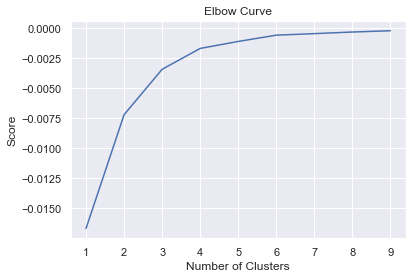

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df1[['lat']]
X_axis = df1[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize the 
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## 3 Clusters... now what?

Now that we have identified the optimal number of clusters to utilize, we must cluster the different vegetarian venues into the 3. To do this, we specify the number of n clusters as 3, fit the model given dataset X (which was derived from the Foursquare API), and add a new column with each venue's cluster.

In [13]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(5)

,venue.name,lat,lng,cluster_label
0,Fresh On Front,43.647815,-79.374453,0
1,Buddha's Vegetarian,43.651904,-79.403312,0
2,Karine's,43.653699,-79.390743,0
3,Vegetarian Haven,43.656016,-79.392758,0
4,Fresh On Spadina,43.648048,-79.396008,0


## Let's visualize the results

First step is let's see in a scatter plot what the newly created cluster model produced. 

The gray circles represent the center of the clusters and we will use those coordinates over our Folium map to identify which neighborhood is best for those with vegetarian diets.

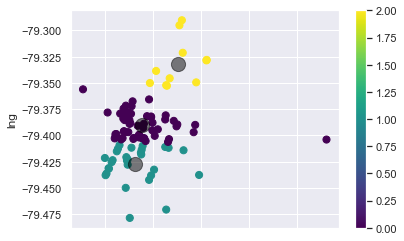

In [14]:
X.plot.scatter(x = 'lat', y = 'lng', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## How many vegetarian restaurants per cluster? 

Let's find out how many vegetarian restaurants there are per cluster. 

From the code below, we see that cluster 0 has the most restaurants at 61.

In [15]:
X['cluster_label'].value_counts()

0    59
1    30
2    11
Name: cluster_label, dtype: int64

## What are the coordinates for each cluster center?

Now that we know how many restaurants there are per cluster, let's calculate the center point for each cluster in order to map it.

In [16]:
center = X.groupby('cluster_label').mean()
center['cluster'] = [0, 1, 2]
center.reset_index(drop=True, inplace=True)
center

,lat,lng,cluster
0,43.655535,-79.390221,0
1,43.652432,-79.427239,1
2,43.670659,-79.331983,2


## Adding the cluster center points to the neighborhoods map

Now that we know the coordinates for the cluster center points, we can overlay them on the neighborhoods map. We know that cluster 2 has the most restaurants so therefore we will show that point as red and the others cyan.



In [18]:
# add clusters to neighborhood map
for lat, lng, cluster in zip(center['lat'], center['lng'], center['cluster']):
    label = '{}'.format(cluster)
    label = folium.Popup(label, parse_html=True)
    if cluster == 0:
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            popup=label,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_toronto) 
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            popup=label,
            color='cyan',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_toronto)  
    
map_toronto

## Let's figure out which neighborhoods are the closest to cluster 2

To do this, I will be using the Pythagorean Theorem to calculate the distance (d) between two points:

$ d = \sqrt{|y_{2} - y_{1}|^{2} + |x_{2} - x_{1}|^{2}} $

### Recall the dataframe we are working with:

In [189]:
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,M7A,43.662301,-79.389494


### Adding a new column that shows us the distance between each neighborhood and cluster 2

From here we can see the top 10 neighborhoods closest to cluster 2.

In [23]:
neighborhoods['dist_2'] = np.sqrt((abs(neighborhoods['Latitude'] - 43.654313)**2) + (abs(neighborhoods['Longitude'] - (-79.390475))**2))
neighborhoods.sort_values(by = ['dist_2'], inplace = True)
neighborhoods.head(10)

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude,dist_2
24,M5G,Downtown Toronto,Central Bay Street,M5G,43.657952,-79.387383,0.004776
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",M5H,43.650571,-79.384568,0.006993
4,M7A,Queen's Park,Ontario Provincial Government,M7A,43.662301,-79.389494,0.008049
84,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",M5T,43.653206,-79.400049,0.009638
97,M5X,Downtown Toronto,"First Canadian Place, Underground city",M5X,43.648429,-79.382280,0.010088
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",M5K,43.647177,-79.381576,0.011407
9,M5B,Downtown Toronto,"Garden District, Ryerson",M5B,43.657162,-79.378937,0.011884
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",M5L,43.648198,-79.379817,0.012287
80,M5S,Downtown Toronto,"University of Toronto, Harbord",M5S,43.662696,-79.400049,0.012725
99,M4Y,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160,0.013669


## The top 10 neighborhoods for those who have vegetarian diets in Toronto, Canada.

In [24]:
neighborhoods['Neighborhood'].head(10)

24                           Central Bay Street
30                     Richmond, Adelaide, King
4                 Ontario Provincial Government
84    Kensington Market, Chinatown, Grange Park
97       First Canadian Place, Underground city
42     Toronto Dominion Centre, Design Exchange
9                      Garden District, Ryerson
48               Commerce Court, Victoria Hotel
80               University of Toronto, Harbord
99                         Church and Wellesley
Name: Neighborhood, dtype: object